In [1]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [2]:
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_subset_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 1996
end_year = 2015
exclude_countries = []
pickle_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2'
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
plm_formula = 'ENI ~ lag(ENI, 1:2) + POP + AFL + AFL2 + URB + CTS + TI + KAOPEN | lag(ENI, 2:99)'
plm_params = {
    'effect': 'twoways',
    'model': 'twostep',
    'collapse': False,
    'transformation': 'd',
}

In [3]:
# Parameters
dataset_file = "/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv"
index_fields = ["Country", "Year"]
data_fields = ["ENI", "POP", "URB", "AFL", "TI", "TS", "CTS", "KAOPEN"]
prefix = "template"
start_year = 2003
end_year = 2015
exclude_countries = []
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
pickle_file = "/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_2003_2015.pickle.bz2"


**End of parameter section** 

In [4]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get pdynmc_params plm_formula plm_params

# SoS mangles dict keys, for no apparent reason
names(pdynmc_params) <- gsub('_', '.', names(pdynmc_params))
names(plm_params) <- gsub('_', '.', names(plm_params))

suppressMessages({
library(dplyr)
library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))

Country,min,max
<fct>,<int>,<int>
ALB,2003,2011
ARG,2003,2014
ARM,2005,2014
AUS,2003,2015
AUT,2003,2015
AZE,2003,2014


In [5]:
pdynmc_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] FALSE

$use.mc.nonlin
[1] FALSE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"    "AFL"    "AFL2"   "URB"    "CTS"    "TI"     "KAOPEN"

$lagTerms.reg.fur
[1] 0 0 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "twostep"

$opt.meth
[1] "none"

$inst.stata
[1] FALSE

In [6]:
pdynmc_base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(pdynmc_base_params, pdynmc_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary


Dynamic linear panel estimation (twostep)
Estimation steps: 2

Coefficients:
            Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)    
L1.ENI     3.568e-01   1.082e-01       3.297      0.00098 ***
L2.ENI     6.384e-02   5.025e-02       1.270      0.20408    
L0.POP     6.251e-02   2.149e-01       0.291      0.77105    
L0.AFL    -6.483e-01   4.896e-01      -1.324      0.18550    
L0.AFL2    3.326e-05   2.583e-02       0.001      0.99920    
L0.URB     4.873e-01   3.181e-01       1.532      0.12552    
L0.CTS     3.439e-02   2.082e-02       1.652      0.09853 .  
L0.TI     -5.393e-03   7.440e-03      -0.725      0.46845    
L0.KAOPEN  3.798e-03   8.149e-03       0.466      0.64122    
2006       6.842e-03   8.344e-03       0.820      0.41222    
2007       1.700e-02   1.524e-02       1.115      0.26485    
2008       2.837e-02   2.402e-02       1.181      0.23760    
2009       2.085e-02   2.865e-02       0.728      0.46661    
2010       3.767e-02   3.202e-02       1.177      0.23


Call:
lm(formula = residuals ~ fitted, data = pdynmc_resid)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.265714 -0.029681 -0.000456  0.028337  0.241882 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.013081   0.002818  -4.643 4.04e-06 ***
fitted      -0.301625   0.048178  -6.261 6.36e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05279 on 771 degrees of freedom
  (117 observations deleted due to missingness)
Multiple R-squared:  0.04838,	Adjusted R-squared:  0.04714 
F-statistic:  39.2 on 1 and 771 DF,  p-value: 6.363e-10


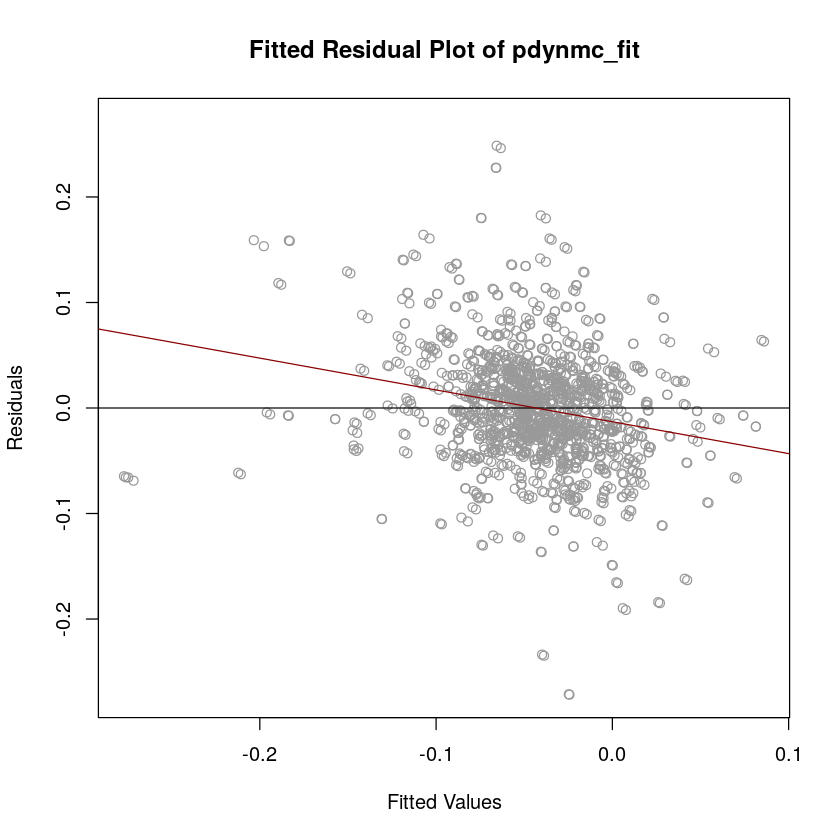

In [7]:
pdynmc_resid <- data.frame(residuals=unlist(residuals(pdynmc_fit)),
                           fitted=unlist(fitted.values(pdynmc_fit)))
resid.reg <- lm(residuals ~ fitted, data=pdynmc_resid)
plot(pdynmc_fit)
abline(resid.reg, col='darkred')
summary(resid.reg)

In [8]:
jtest.fct(pdynmc_fit)
ser.corr1 <- mtest.fct(pdynmc_fit, t.order = 1)
ser.corr1
ser.corr2 <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr2


	J-Test of Hansen

data:  2step GMM Estimation; H0: overidentifying restrictions valid
chisq = 74.935, df = 63, p-value = 0.1443


Warning message in mtest.fct(pdynmc_fit, t.order = 1):
“Absolute value of denominator of test statistic was used in the computation.”



	Arrelano and Bond (1991) serial correlation test of degree 1

data:  2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
normal = -2.8615, p-value = 0.004216


Warning message in mtest.fct(pdynmc_fit, t.order = 2):
“Absolute value of denominator of test statistic was used in the computation.”



	Arrelano and Bond (1991) serial correlation test of degree 2

data:  2step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = -0.22355, p-value = 0.8231


In [9]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr1, ser.corr2),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,74.935285,chisq,1.442878e-01,2step GMM Estimation; H0: overidentifying restrictions valid
Wald test,264.558391,chisq,8.375430e-52,2step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,25.948677,chisq,3.809830e-03,2step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 1,-2.861548,normal,4.215776e-03,2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
Arrelano and Bond (1991) serial correlation test of degree 2,-0.223552,normal,8.231059e-01,2step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [10]:
# plm.formula <- as.formula(plm_formula)
# plm.params = modifyList(list(plm.formula,
#                              data=data.panel),
#                         plm_params)
# z2 <- do.call(pgmm, plm.params)
# z2$call <- plm.formula
# summary(z2, robust = TRUE)

In [11]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)

In [12]:
%get pdynmc_coef pdynmc_tests pdynmc_resid --from R
import pickle
import bz2

with bz2.BZ2File(pickle_file, 'w') as fd:
    pickle.dump({
        'pdynmc_coef': pdynmc_coef,
        'pdynmc_tests': pdynmc_tests,
        'pdynmc_resid': pdynmc_resid,
        'pdynmc_params': pdynmc_params,
        'start_year': start_year,
        'end_year': start_year,
        'varname.reg.fur': start_year,
        'start_year': start_year,
    }, fd)